## Imports

Note: you may need to restart the kernel to use updated packages.


In [1]:
# loading data
import pandas as pd
import string
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
# numeric pro
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Regular Expression for text cleaning
import re

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models
#nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



# Word2vec
import gensim
import gensim.downloader as gensim_api

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc
from sklearn.manifold import TSNE

#bert 
import transformers



## Data exploration & Analysis

In [10]:
df_train = pd.read_csv("train-balanced-sarcasm.csv")

In [4]:
df_train.head(4)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz


In [5]:
df_train.describe()

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


In [68]:
df_train.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [6]:
len(df_train)

1010826

In [70]:
df_train.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [71]:
df_train = df_train.drop(columns={'author','date','created_utc','subreddit','score','ups','downs','parent_comment'})

In [72]:
df_train

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.
...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...
1010822,1,"whatever you do, don't vote green!"
1010823,1,Perhaps this is an atheist conspiracy to make ...
1010824,1,The Slavs got their own country - it is called...


In [73]:
df_train['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

#### Data Distribution

<AxesSubplot:xlabel='comment', ylabel='label'>

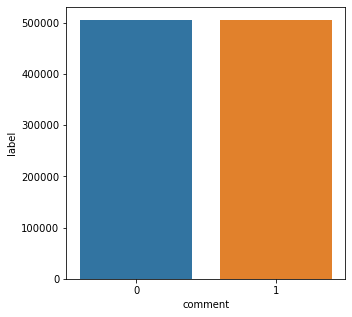

In [74]:
cum = df_train['label'].value_counts().to_frame()
cum['comment'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sns.barplot(data=cum,x='comment',y='label',ax=ax)

#### Length of sarcastic and no sarcastic comments

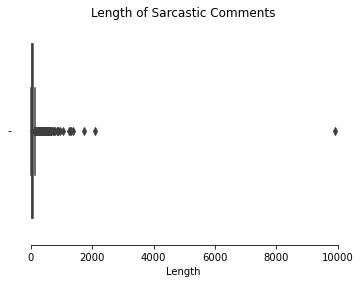

In [75]:
sns.boxplot(x= df_train.loc[df_train['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=5, trim=True)
plt.show()

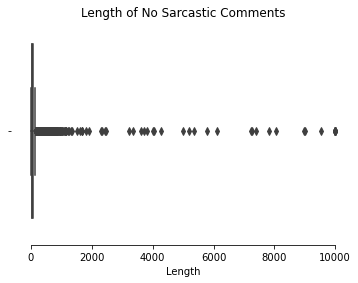

In [76]:
sns.boxplot(x= df_train.loc[df_train['label'] == 0, 'comment'].str.len()).set(title = 'Length of No Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=5, trim=True)
plt.show()

#### word cloud

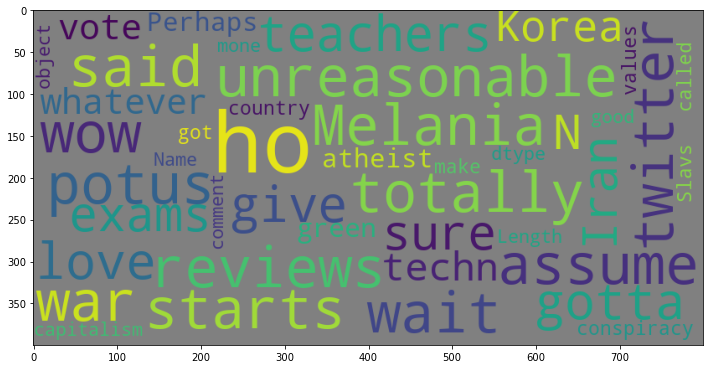

In [77]:
wordcloud = WordCloud(background_color='grey', stopwords = STOPWORDS,
                max_words = 500, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(df_train.loc[df_train['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

## Data preprocessing

Machine learning models don't work with abreviations and contraction so we should replace them with contracted words with their non contracted version

In [78]:
contractions = pd.read_csv("contractions.csv")
contractions.head(4)

,Contraction,Meaning
0,'aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not


In [79]:
# we have some emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [80]:
word = "isn't"
ww = word in contractions.Contraction.values
contractions[contractions.Contraction==word].Meaning.values[0]

'is not'

In [81]:
def cleaning_text(s):
    s = str(s).lower().strip()
    s = " ".join([contractions[contractions.Contraction==word].Meaning.values[0] if word in contractions.Contraction.values else word for word in s.split()])
    s = " ".join([emojis[word] if word in emojis.keys() else word for word in s.split()])

    # removing \n
    sss = '\n'
    s = re.sub(sss, '', s)
    # put spaces before & after punctuations to make words seprate
    s = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", s)
    # Remove >=2 continues spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

In [2]:
""""df_train.comment = df_train.comment.apply(cleaning_text)
df_train.to_pickle("a_file.pkl")"""
df_train = pd.read_pickle("cleanText.pkl")
comments = df_train['comment'].values
labels = df_train['label'].values

In [83]:
comments[3]

'this meme is not funny none of the new york nigga ones are'

In [84]:
comments

array(['nc and nh',
       'you do know west teams play against west teams more than east teams right',
       'they were underdogs earlier today but since gronks announcement this afternoon the vegas line has moved to patriots 1',
       ...,
       'perhaps this is an atheist conspiracy to make christians look bad',
       'the slavs got their own country it is called kosovo',
       'values as in capitalism there is good money in imprisoning people'],
      dtype=object)

In [85]:
df_train

,label,comment
0,0,nc and nh
1,0,you do know west teams play against west teams...
2,0,they were underdogs earlier today but since gr...
3,0,this meme is not funny none of the new york ni...
4,0,i could use one of those tools
...,...,...
1010821,1,im sure that iran and n korea have the technol...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this is an atheist conspiracy to make ...
1010824,1,the slavs got their own country it is called k...


## Vectorize

In [86]:
# settings that you use for count vectorizer will go here 
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
 
data_train= vectorizer.fit_transform(comments)
data_train

<1010826x207002 sparse matrix of type '<class 'numpy.float64'>'
	with 4926753 stored elements in Compressed Sparse Row format>

In [87]:
c_t,c_test,l_t,l_test = train_test_split(data_train,labels,test_size=0.20)

In [88]:
data_train

<1010826x207002 sparse matrix of type '<class 'numpy.float64'>'
	with 4926753 stored elements in Compressed Sparse Row format>

In [89]:
print(vectorizer.idf_)

[10.87503565 10.7832281  12.62905479 ... 14.13313219 14.13313219
 14.13313219]


# WORD2VEC


In [27]:
df_test = df_train[800000:]
df_train = df_train[:800000]

df_test

,label,comment
800000,1,ok but the real question is what were you wearing
800001,0,yep grubi
800002,0,who says you cant
800003,1,what sort of beta fag writes poetry
800004,1,i know let us get more adorable cat videos ins...
...,...,...
1010821,1,im sure that iran and n korea have the technol...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this is an atheist conspiracy to make ...
1010824,1,the slavs got their own country it is called k...


In [109]:
nlp = gensim_api.load("word2vec-google-news-300")

ValueError: Incorrect model/corpus name

In [29]:
corpus = df_train["comment"]
corpus

0                                                 nc and nh
1         you do know west teams play against west teams...
2         they were underdogs earlier today but since gr...
3         this meme is not funny none of the new york ni...
4                            i could use one of those tools
                                ...                        
799995    they have already said they are working on a n...
799996    omni not viable anymore after removal of small...
799997    that and the faker who supports anita were pri...
799998    but but why would i want to ruin the silky smo...
799999              i blame it on the chemtrails personally
Name: comment, Length: 800000, dtype: object

In [30]:
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

In [31]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300,   
            window=8, min_count=1)

In [97]:
vocab = list(nlp.wv.key_to_index)
X = nlp.wv[vocab[:5000]]

X[0]

array([-5.3226995e-01,  6.3320541e-01,  4.1641808e-01,  4.0685797e+00,
        3.9880857e-01, -1.3765493e-01,  1.8052654e+00, -8.1515580e-01,
       -7.0983696e-01,  8.8460106e-01,  6.4400315e-01, -5.6644952e-01,
       -7.6658010e-01,  4.0383270e-01,  1.0579389e-01, -4.0482852e-01,
        1.0417603e+00, -7.0836896e-01, -1.1143858e+00,  5.5113119e-01,
        1.5451132e+00,  9.8097295e-02,  1.0754553e+00, -3.8914987e-01,
       -5.6353146e-01,  8.9386445e-01,  1.4134390e+00,  4.7380340e-01,
        2.7274227e-01, -3.0535045e-01,  1.1127084e+00,  3.6142918e-01,
        1.3351323e-01, -5.9932923e-01, -2.3772960e+00,  3.5792384e-01,
       -9.4004941e-01,  4.0800750e-01, -8.3251208e-01,  9.6517217e-01,
       -9.7970533e-01,  4.8551012e-02,  2.8989130e-01, -3.7151599e-01,
        1.1865695e+00,  2.3826359e-01,  2.3820405e-04, -8.1308506e-02,
        3.8833368e-01,  6.6778101e-02, -4.1487551e-01, -5.1652843e-01,
        3.0909082e-01, -3.1038183e-01,  1.1609157e+00, -1.6084924e+00,
      

In [33]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)



array([-11.38058,  24.86272], dtype=float32)

In [105]:
dfW2V = pd.DataFrame(X_tsne, index=vocab[:5000], columns=['x', 'y'])
name = []
for word, pos in dfW2V.iterrows():
    name.append(word)
dfW2V["name"]= name
dfW2V


,x,y,name
the,-11.380580,24.862720,the
is,19.114283,-33.282799,is
to,-34.257931,17.702646,to
a,-7.931242,28.271591,a
you,-11.382378,33.291107,you
...,...,...,...
bf,-6.641433,-2.400127,bf
bundle,13.080260,30.479465,bundle
pockets,-5.408317,1.104040,pockets
transparent,-13.782898,-51.627769,transparent


In [106]:
import plotly.express as px


fig = px.scatter(dfW2V, x="x", y="y", text ="name", log_x=True, size_max=100)
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Representation des mots', title_x=0.5)


fig.show()


In [107]:
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index



In [37]:
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

In [38]:
lst_text2seq

[[4743, 9, 14257],
 [6, 21, 62, 1020, 609, 150, 243, 1020, 609, 58, 79, 1104, 609, 71],
 [17,
  95,
  18829,
  1835,
  503,
  16,
  190,
  34351,
  4439,
  18,
  7337,
  2,
  3265,
  460,
  54,
  2071,
  4,
  2706,
  224],
 [18, 931, 3, 10, 338, 890, 12, 2, 133, 2267, 4744, 393, 14],
 [7, 87, 123, 48, 12, 93, 3374],
 [7,
  21,
  10,
  304,
  952,
  4,
  111,
  16,
  35,
  221,
  35,
  81,
  54,
  956,
  7,
  33,
  10,
  1447,
  111,
  57,
  12,
  1620,
  144,
  81,
  463,
  5,
  2022],
 [2063, 46, 4800, 13, 869, 3, 25, 613],
 [2966, 73097, 46, 3252],
 [6, 21, 10, 19, 4, 6, 19, 5, 67, 534, 254, 225, 46, 584, 8],
 [7, 33, 145, 4, 88, 82, 41, 53549],
 [7, 64, 5, 2859, 668, 33, 20, 243, 1627, 68, 714, 911, 22, 112, 43],
 [248, 7, 26, 1114, 204, 26, 162],
 [17, 19, 50, 2076],
 [126, 294],
 [1245, 3177, 28726, 8, 170, 5, 351, 58, 343, 13, 1488],
 [34, 2, 89],
 [7423],
 [31, 8, 3, 34, 76, 7029, 82, 9, 8, 3, 5, 738, 12, 7492],
 [72, 6, 1822, 52, 38, 3452],
 [73098, 9540, 9, 22440],
 [81,
  742

In [57]:
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=50, padding="post", truncating="post")


In [40]:
"""sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()"""


'sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)\nplt.show()'

In [108]:
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

embeddings.most_similar("the")

AttributeError: 'numpy.ndarray' object has no attribute 'most_similar'

In [58]:
corpus = df_test["comment"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

X_test


array([[  283,    16,     2, ...,     0,     0,     0],
       [  434,     1,     0, ...,     0,     0,     0],
       [   69,   337,     6, ...,     0,     0,     0],
       ...,
       [ 1201,    18,     3, ...,     0,     0,     0],
       [    2, 16600,    91, ...,     0,     0,     0],
       [ 2561,    35,    13, ...,     0,     0,     0]])

In [43]:
Y_train = df_train["label"]
Y_test = df_test["label"]



# Word2Vec NNL

In [62]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 15, 300)      55066200    ['input_3[0][0]']                
                                                                                                  
 permute_2 (Permute)            (None, 300, 15)      0           ['embedding_2[0][0]']            
                                                                                                  
 dense_6 (Dense)                (None, 300, 15)      240         ['permute_2[0][0]']              
                                                                                            

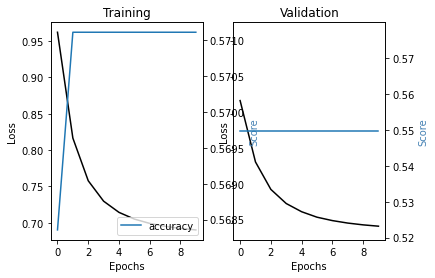

In [63]:

## train
#training = model.fit(x=X_train, y=Y_train, batch_size=256, 
 #                    epochs=10, shuffle=True, verbose=0, 
  #                   validation_split=0.3)

In [110]:
#predicted_prob = model.evaluate(X_test, Y_test)


6589/6589 [==============================] - 21s 3ms/step - loss: 0.7215 - accuracy: 0.4556


210826

# W2V TEST 2


In [16]:
df_train

,label,comment
0,0,nc and nh
1,0,you do know west teams play against west teams...
2,0,they were underdogs earlier today but since gr...
3,0,this meme is not funny none of the new york ni...
4,0,i could use one of those tools
...,...,...
1010821,1,im sure that iran and n korea have the technol...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this is an atheist conspiracy to make ...
1010824,1,the slavs got their own country it is called k...


# BERT

In [3]:
import torch

In [53]:
indexNames = df_train[df_train["comment"].map(len) > 512 ].index
indexNames
df_train = df_train.drop(indexNames)
df_trainX = df_train[:10000] 

In [55]:
indexNames = df_train[df_train["comment"].map(len) > 512 ].index
indexNames

Int64Index([], dtype='int64')

In [56]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
    

In [57]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
tokenized = df_trainX["comment"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, padding = True)))


In [59]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


In [60]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape


(10000, 99)

In [61]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)



KeyboardInterrupt: 

In [49]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df_trainX["label"]

In [50]:
from sklearn.linear_model import LogisticRegression

train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(train_features, train_labels)

LogisticRegression(max_iter=1000)

In [52]:
lr_clf.score(test_features, test_labels)

0.7426666666666667

# Baseline models

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

classifier1 = LogisticRegression(solver='saga', max_iter=1000)
classifier1.fit(X_train, Y_train)
score1 = classifier1.score(X_test, Y_test)

print("Accuracy:", score1)

Accuracy: 0.48819405576162334


In [45]:
l_pred1 = classifier1.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(Y_test, l_pred1)
cm1

array([[81728, 14320],
       [93582, 21196]], dtype=int64)

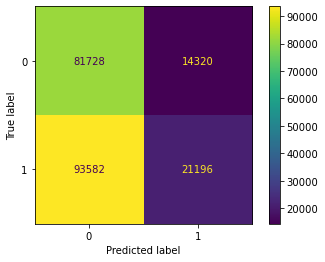

In [47]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier1, X_test,Y_test)  

## Support vector

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
 
classifier2 = LinearSVC()
classifier2.fit(X_train, Y_train)
 #score
score2 = classifier2.score(X_test, Y_test)
print("Accuracy:", score2)
# predicting test set results
l_pred2 = classifier2.predict(X_test)
 
# making the confusion matrix
cm2 = confusion_matrix(Y_test, l_pred2)
cm2

## Naive bayes

In [96]:
from sklearn.naive_bayes import MultinomialNB
 
classifier3 = MultinomialNB().fit(c_t, l_t)
 
# predicting test set results
l_pred3 = classifier3.predict(c_test)
#score
score3 = classifier3.score(c_test, l_test)
print("Accuracy:", score3)
# making the confusion matrix
cm3 = confusion_matrix(l_test, l_pred3)
cm3


Accuracy: 0.6564407467130972


array([[65268, 36017],
       [33439, 67442]], dtype=int64)

## Stochastic gradient descent

In [ ]:
from sklearn.linear_model import SGDClassifier
 
classifier4 = SGDClassifier().fit(X_train, Y_train)
 
# predicting test set results
l_pred4 = classifier4.predict(X_test)
#score
score4 = classifier4.score(X_test, Y_test)
print("Accuracy:", score4)
# making the confusion matrix
cm4 = confusion_matrix(X_test, l_pred4)
cm4
